In [2]:
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, precision_score, recall_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# area under precision recall curve -> binary classification metric
# use decision tree rather than logreg/rf
# also try catboost/lightGBM
# ICA, PCA

In [4]:
ROOT = 'C:\\Users\\curea\\Documents\\bioFM for drug discovery\\dege-fm\\'

adata = ad.read_h5ad(ROOT + "data\\zhao_2021_uce_adata.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 165748 × 18724
    obs: 'sample', 'GEO', 'Sample', 'tissue', 'age', 'sex', 'location', 'diagnosis', 'library', 'dose_value', 'dose_unit', 'perturbation', 'tissue_type', 'cancer', 'disease', 'celltype', 'organism', 'perturbation_type', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID'
    var: 'ncounts', 'ncells'
    obsm: 'X_uce'

In [4]:
adata.obs['perturbation'].unique()

['panobinostat', 'control', 'etoposide', 'Ana-12', 'RO4929097', 'Tazemetostat', 'Ispenisib']
Categories (7, object): ['Ana-12', 'Ispenisib', 'RO4929097', 'Tazemetostat', 'control', 'etoposide', 'panobinostat']

In [25]:
adata.obs['sample'].unique()

['PW032', 'PW036', 'PW040', 'PW052', 'PW030', 'PW031', 'PW053', 'PW029', 'PW051', 'PW034']
Categories (10, object): ['PW029', 'PW030', 'PW031', 'PW032', ..., 'PW040', 'PW051', 'PW052', 'PW053']

In [26]:
adata.obs['Sample'].unique()

['PW032-711', 'PW032-709', 'PW036-705', 'PW032-701', 'PW040-711', ..., 'PW032-702', 'PW030-704', 'PW030-707', 'PW029-702', 'PW032-705']
Length: 43
Categories (43, object): ['PW029-701', 'PW029-702', 'PW030-701', 'PW030-702', ..., 'PW052709', 'PW053707', 'PW053710', 'PW053711']

In [8]:
adata.obs['tissue'].unique()

['glioma surgical biopsy', 'acute slice culture of glioma resection']
Categories (2, object): ['acute slice culture of glioma resection', 'glioma surgical biopsy']

In [6]:
sc.pp.neighbors(adata, use_rep="X_uce")

In [7]:
sc.tl.umap(adata)

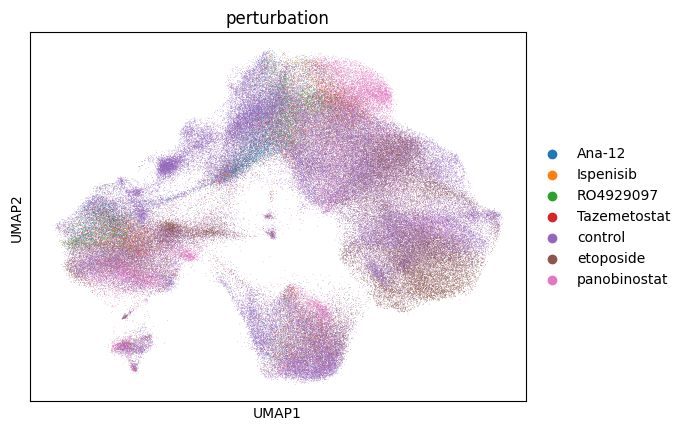

In [8]:
sc.pl.umap(
    adata,
    color="perturbation"
)

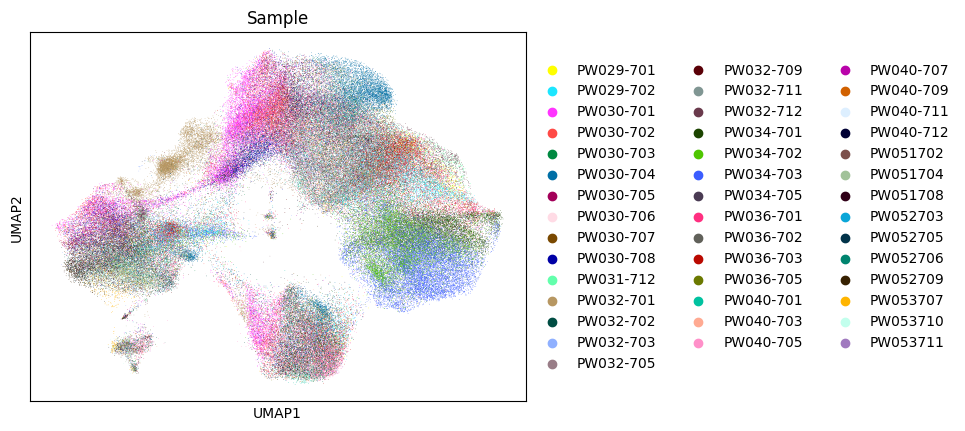

In [9]:
sc.pl.umap(
    adata,
    color="Sample"
)

In [6]:
for sample in list(adata.obs['sample'].unique()):
    adata_subset = adata[adata.obs['sample'] == sample]

    n_cells = adata_subset.n_obs
    treatements = list(adata_subset.obs['perturbation'].unique())
    tissue = list(adata_subset.obs['tissue'].unique())
    diagnosis = list(adata_subset.obs['tissue'].unique())
    dose = list(adata_subset.obs['dose_value'].unique())
    dose_unit = list(adata_subset.obs['dose_unit'].unique())

    print(sample)
    print("\t", "No cells:", n_cells)
    print("\t", "Treatements:", treatements)
    print("\t", "Tissues:", tissue)
    print("\t", "Diagnosis", diagnosis)
    print("\t", "Dose:", dose)
    print("\t", "Dose Unit", dose_unit)

PW032
	 No cells: 20751
	 Treatements: ['panobinostat', 'control', 'etoposide']
	 Tissues: ['glioma surgical biopsy']
	 Diagnosis ['glioma surgical biopsy']
	 Dose: ['0.2', nan, '2.5']
	 Dose Unit ['uM', nan]
PW036
	 No cells: 22505
	 Treatements: ['panobinostat', 'control', 'etoposide']
	 Tissues: ['acute slice culture of glioma resection']
	 Diagnosis ['acute slice culture of glioma resection']
	 Dose: ['0.2', nan, '2.5']
	 Dose Unit ['uM', nan]
PW040
	 No cells: 16269
	 Treatements: ['control', 'panobinostat']
	 Tissues: ['acute slice culture of glioma resection']
	 Diagnosis ['acute slice culture of glioma resection']
	 Dose: [nan, '0.2']
	 Dose Unit [nan, 'uM']
PW052
	 No cells: 4883
	 Treatements: ['etoposide', 'control']
	 Tissues: ['acute slice culture of glioma resection']
	 Diagnosis ['acute slice culture of glioma resection']
	 Dose: ['2.5', nan]
	 Dose Unit ['uM', nan]
PW030
	 No cells: 50909
	 Treatements: ['control', 'Ana-12', 'etoposide', 'RO4929097', 'Tazemetostat', 'pa

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, precision_score, recall_score
import seaborn as sns

def evaluate_classifier_logreg(adata):
    for sample in adata.obs['sample'].unique():

        ad = adata[adata.obs['sample'] == sample]

        perturbations = list(ad.obs['perturbation'].unique())
        print(perturbations)
        #build control, perturbed samples
        X_control = ad[ad.obs['perturbation'] == "control"].obsm['X_uce']
        y_control = [0 for _ in range(X_control.shape[0])]

        #for each individual treatment, build a classifier
        for prt in perturbations:
            if prt == 'control':
                continue

            X_prt = ad[ad.obs['perturbation'] == prt].obsm['X_uce']
            y_prt = [1 for _ in range(X_prt.shape[0])]

            X = np.vstack((X_control, X_prt))
            y = np.array(y_control + y_prt)

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1702)

            classifier = LogisticRegression(random_state=1702, max_iter=1000, class_weight='balanced')
            classifier.fit(X_train, y_train)

            y_pred = classifier.predict(X_test)
            y_pred_proba = classifier.predict_proba(X_test)[:, 1]

            # Calculate performance metrics
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Control", "Perturbed"]))



            # Calculate confusion matrix and plot it
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 4))

            # Confusion Matrix Plot
            plt.subplot(1, 2, 1)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Treatment'], yticklabels=['Control', 'Treatment'])
            plt.title(f"Confusion Matrix - {sample} ({prt})")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")

            # Precision-Recall Curve Plot
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = auc(recall, precision)
            plt.subplot(1, 2, 2)
            plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"Precision-Recall Curve - {sample} ({prt})")
            plt.legend()

            # Show both plots together for each treatment
            plt.tight_layout()
            plt.show()


['panobinostat', 'control', 'etoposide']
Classification Report:
               precision    recall  f1-score   support

     Control       0.99      0.89      0.94      3369
   Perturbed       0.41      0.87      0.56       280

    accuracy                           0.89      3649
   macro avg       0.70      0.88      0.75      3649
weighted avg       0.94      0.89      0.91      3649



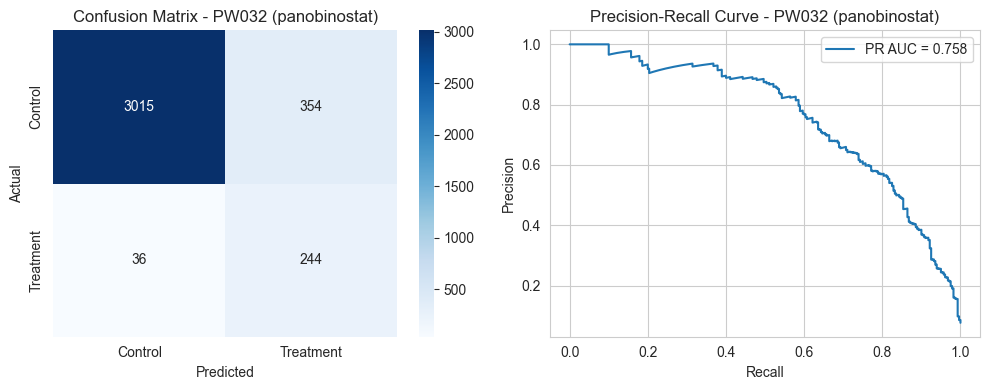

Classification Report:
               precision    recall  f1-score   support

     Control       0.98      0.83      0.90      3368
   Perturbed       0.43      0.86      0.58       502

    accuracy                           0.84      3870
   macro avg       0.70      0.85      0.74      3870
weighted avg       0.91      0.84      0.86      3870



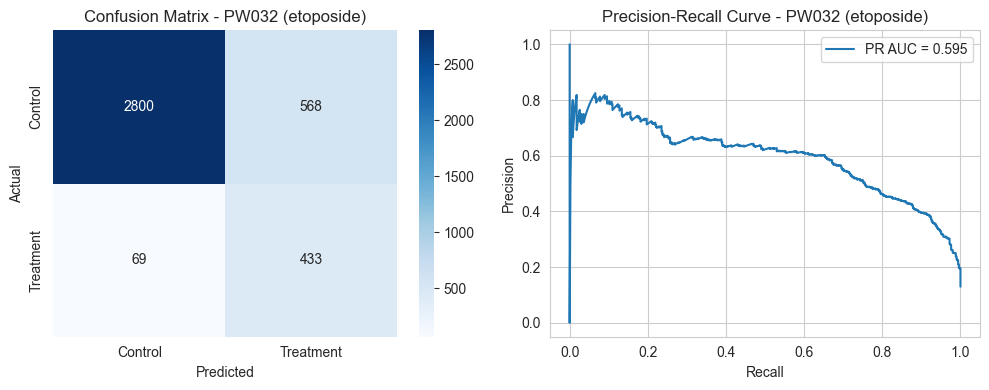

['panobinostat', 'control', 'etoposide']
Classification Report:
               precision    recall  f1-score   support

     Control       0.97      0.91      0.94      2658
   Perturbed       0.70      0.90      0.78       619

    accuracy                           0.91      3277
   macro avg       0.84      0.90      0.86      3277
weighted avg       0.92      0.91      0.91      3277



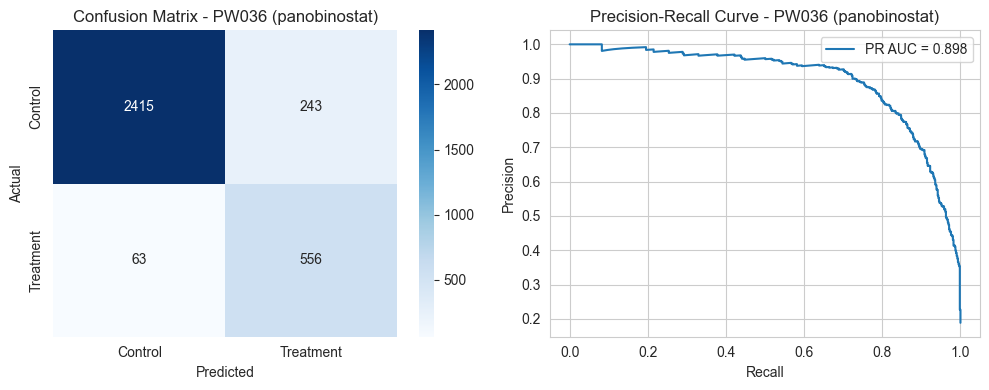

Classification Report:
               precision    recall  f1-score   support

     Control       0.93      0.81      0.86      2658
   Perturbed       0.67      0.86      0.75      1224

    accuracy                           0.82      3882
   macro avg       0.80      0.83      0.81      3882
weighted avg       0.85      0.82      0.83      3882



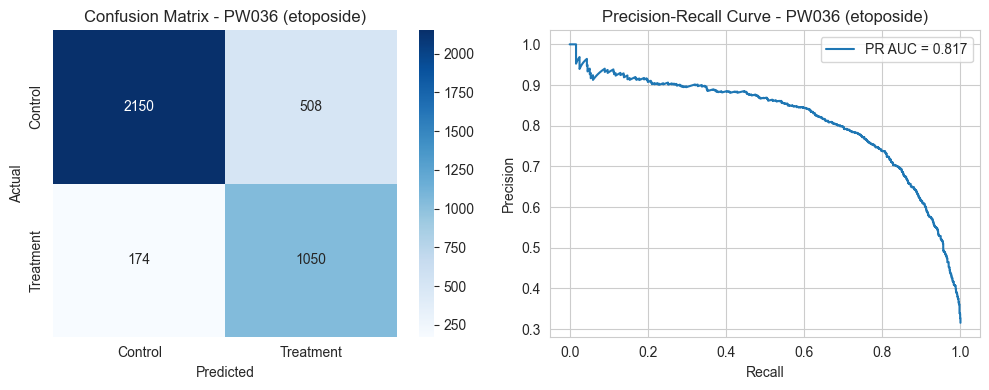

['control', 'panobinostat']
Classification Report:
               precision    recall  f1-score   support

     Control       0.96      0.82      0.88      2857
   Perturbed       0.37      0.77      0.50       397

    accuracy                           0.81      3254
   macro avg       0.66      0.79      0.69      3254
weighted avg       0.89      0.81      0.84      3254



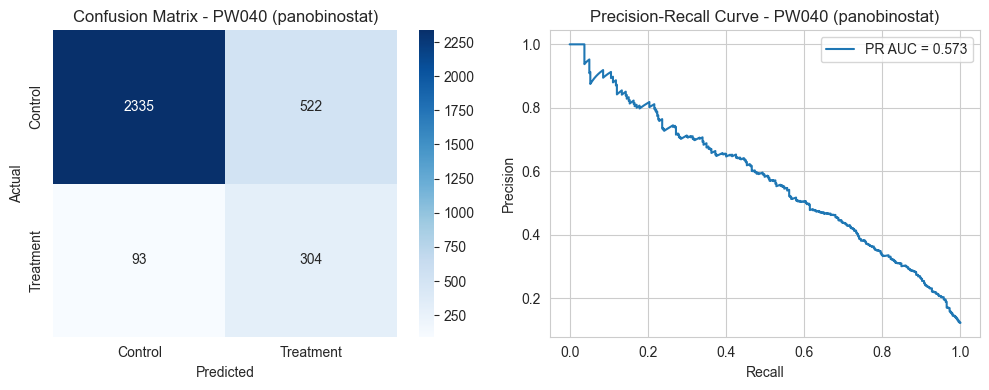

['etoposide', 'control']
Classification Report:
               precision    recall  f1-score   support

     Control       0.67      0.86      0.75       258
   Perturbed       0.94      0.85      0.89       719

    accuracy                           0.85       977
   macro avg       0.81      0.85      0.82       977
weighted avg       0.87      0.85      0.85       977



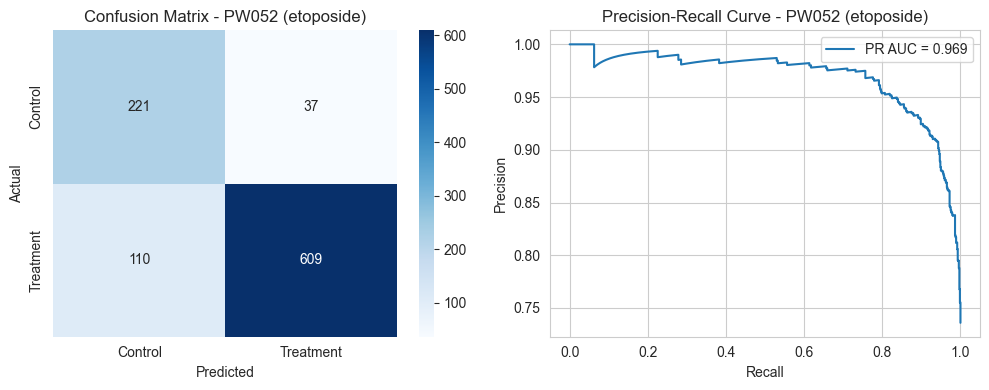

['control', 'Ana-12', 'etoposide', 'RO4929097', 'Tazemetostat', 'panobinostat', 'Ispenisib']
Classification Report:
               precision    recall  f1-score   support

     Control       0.96      0.91      0.93      4230
   Perturbed       0.77      0.88      0.82      1417

    accuracy                           0.90      5647
   macro avg       0.86      0.90      0.88      5647
weighted avg       0.91      0.90      0.91      5647



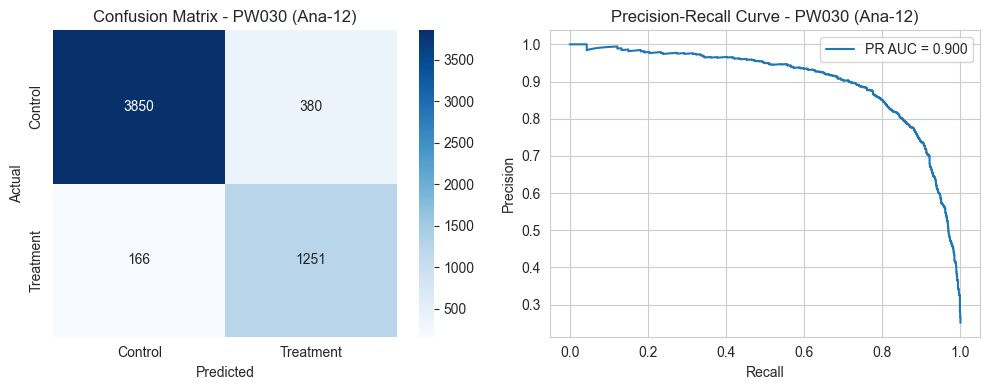

Classification Report:
               precision    recall  f1-score   support

     Control       1.00      0.98      0.99      4230
   Perturbed       0.89      0.98      0.94       788

    accuracy                           0.98      5018
   macro avg       0.95      0.98      0.96      5018
weighted avg       0.98      0.98      0.98      5018



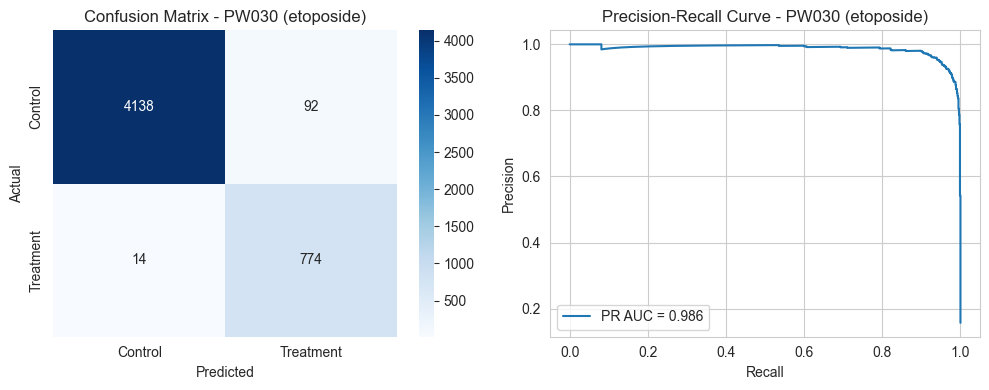

Classification Report:
               precision    recall  f1-score   support

     Control       0.99      0.95      0.97      4230
   Perturbed       0.82      0.94      0.88       961

    accuracy                           0.95      5191
   macro avg       0.90      0.95      0.92      5191
weighted avg       0.96      0.95      0.95      5191



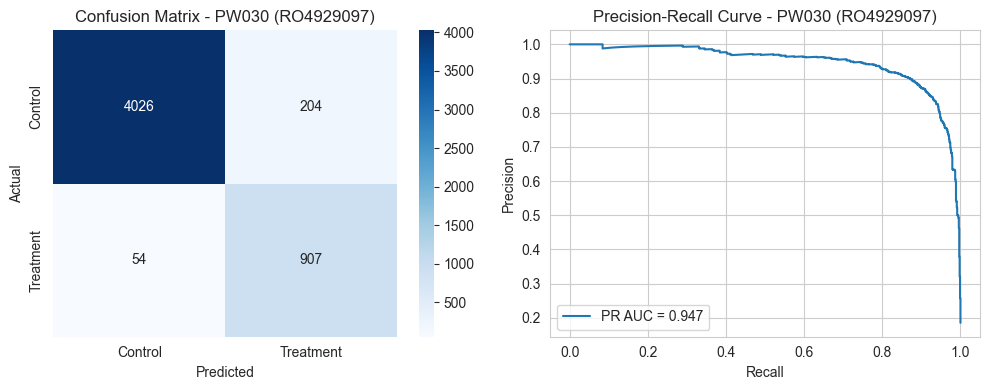

Classification Report:
               precision    recall  f1-score   support

     Control       0.99      0.97      0.98      4229
   Perturbed       0.86      0.95      0.90       826

    accuracy                           0.97      5055
   macro avg       0.92      0.96      0.94      5055
weighted avg       0.97      0.97      0.97      5055



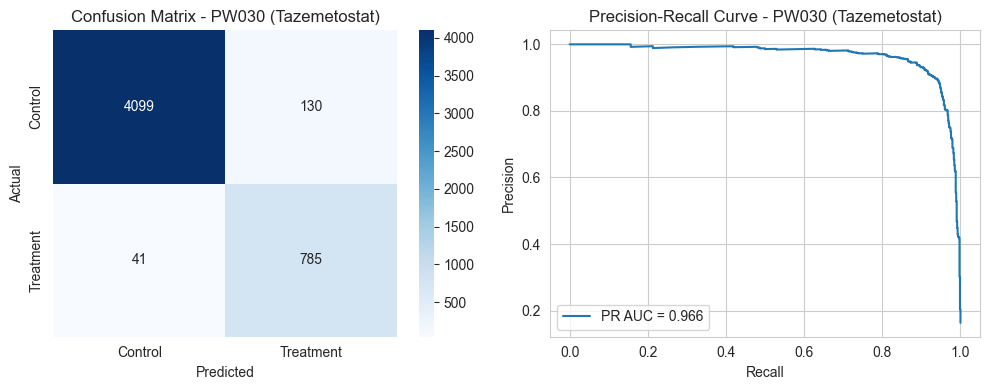

Classification Report:
               precision    recall  f1-score   support

     Control       1.00      0.99      0.99      4229
   Perturbed       0.96      0.99      0.98      1424

    accuracy                           0.99      5653
   macro avg       0.98      0.99      0.98      5653
weighted avg       0.99      0.99      0.99      5653



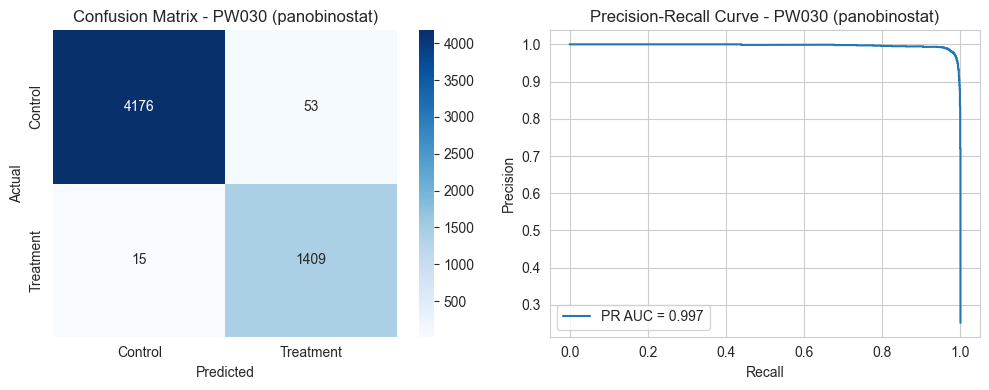

Classification Report:
               precision    recall  f1-score   support

     Control       0.99      0.95      0.97      4229
   Perturbed       0.72      0.95      0.82       537

    accuracy                           0.95      4766
   macro avg       0.86      0.95      0.90      4766
weighted avg       0.96      0.95      0.96      4766



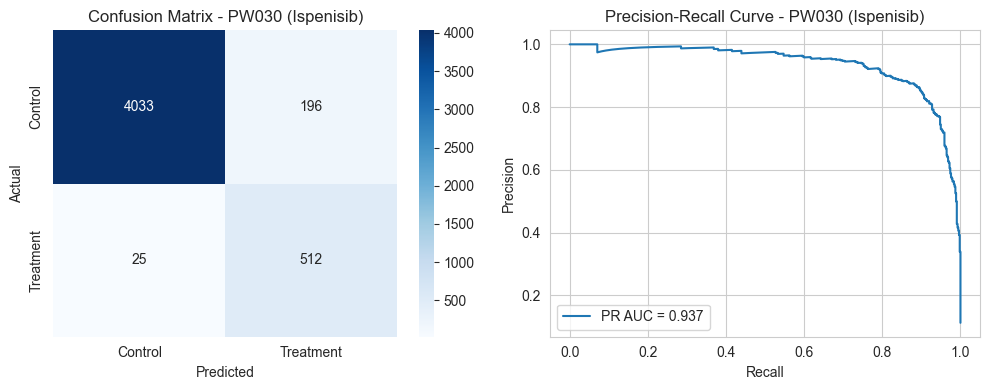

['control']
['panobinostat', 'control']
Classification Report:
               precision    recall  f1-score   support

     Control       0.85      0.93      0.89       276
   Perturbed       0.98      0.94      0.96       812

    accuracy                           0.94      1088
   macro avg       0.91      0.94      0.92      1088
weighted avg       0.94      0.94      0.94      1088



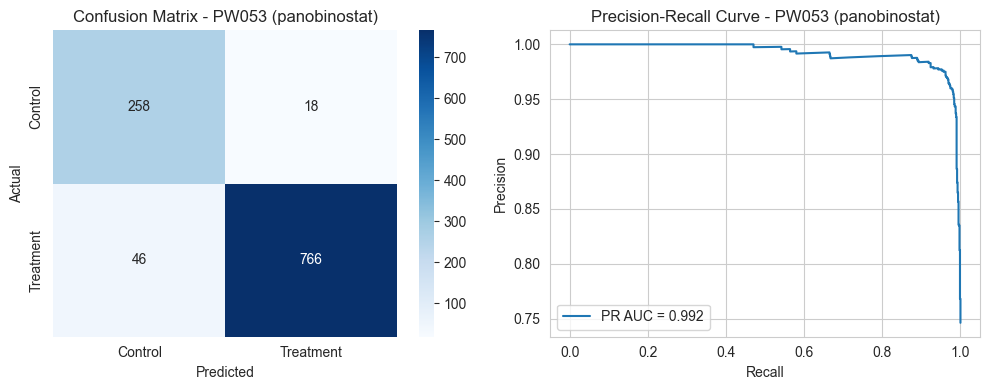

['control', 'etoposide']
Classification Report:
               precision    recall  f1-score   support

     Control       0.78      0.88      0.83       339
   Perturbed       0.95      0.90      0.93       891

    accuracy                           0.90      1230
   macro avg       0.87      0.89      0.88      1230
weighted avg       0.91      0.90      0.90      1230



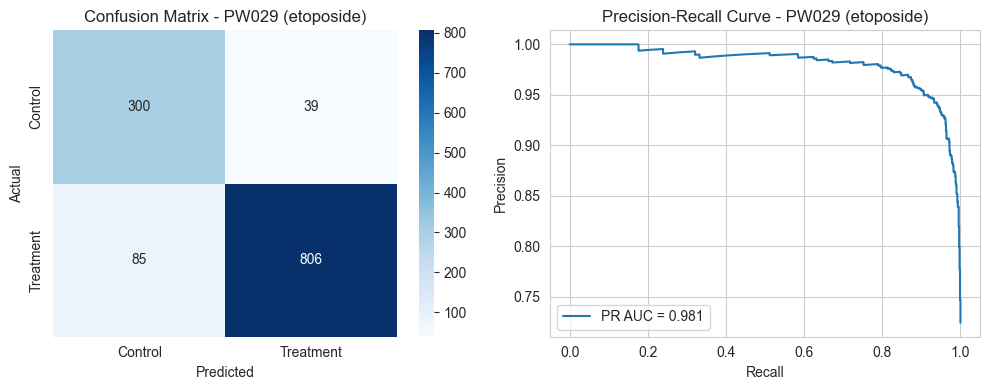

['control', 'panobinostat']
Classification Report:
               precision    recall  f1-score   support

     Control       0.91      0.90      0.90       386
   Perturbed       0.90      0.91      0.90       376

    accuracy                           0.90       762
   macro avg       0.90      0.90      0.90       762
weighted avg       0.90      0.90      0.90       762



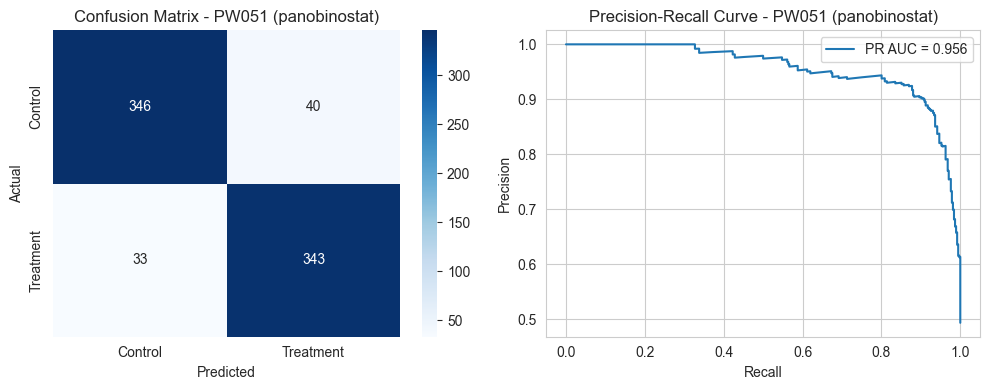

['control', 'panobinostat', 'etoposide']
Classification Report:
               precision    recall  f1-score   support

     Control       0.98      0.94      0.96      3058
   Perturbed       0.73      0.91      0.81       536

    accuracy                           0.94      3594
   macro avg       0.86      0.93      0.89      3594
weighted avg       0.95      0.94      0.94      3594



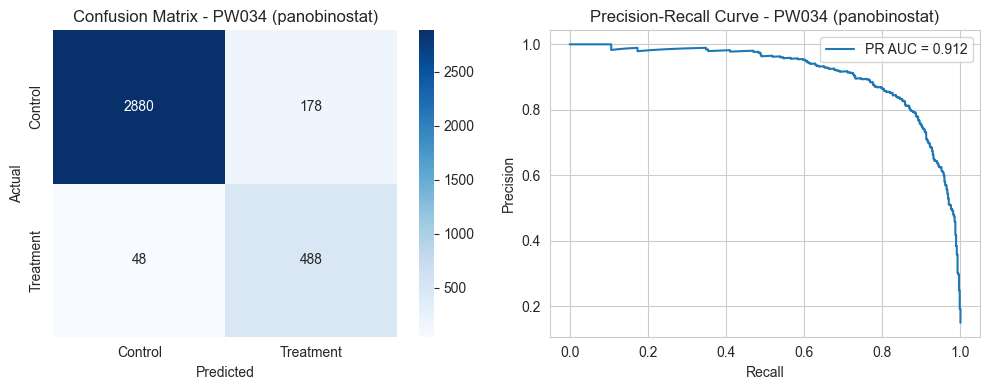

Classification Report:
               precision    recall  f1-score   support

     Control       0.90      0.87      0.88      3058
   Perturbed       0.88      0.90      0.89      3179

    accuracy                           0.89      6237
   macro avg       0.89      0.89      0.89      6237
weighted avg       0.89      0.89      0.89      6237



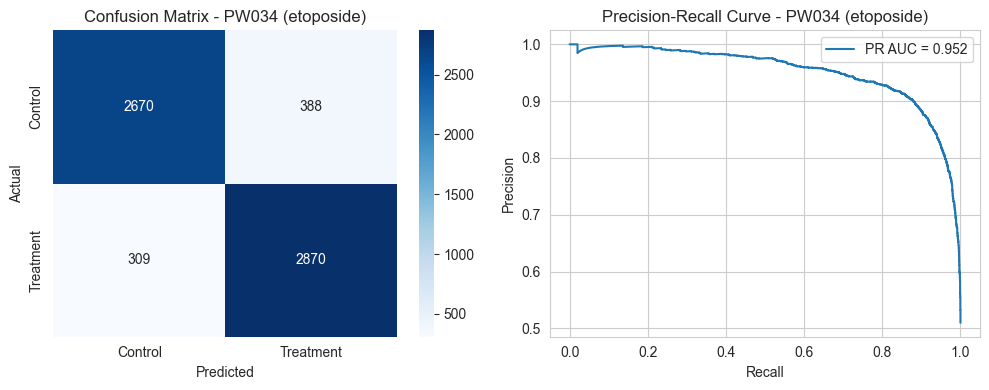

In [32]:
evaluate_classifier_logreg(adata)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, precision_score, recall_score
import seaborn as sns

def evaluate_classifier_rf(adata):
    for sample in adata.obs['sample'].unique():

        ad = adata[adata.obs['sample'] == sample]

        perturbations = list(ad.obs['perturbation'].unique())
        print(perturbations)

        # Build control samples
        X_control = ad[ad.obs['perturbation'] == "control"].obsm['X_uce']
        y_control = [0 for _ in range(X_control.shape[0])]

        # For each individual treatment, build and evaluate a classifier
        for prt in perturbations:
            if prt == 'control':
                continue

            X_prt = ad[ad.obs['perturbation'] == prt].obsm['X_uce']
            y_prt = [1 for _ in range(X_prt.shape[0])]

            X = np.vstack((X_control, X_prt))
            y = np.array(y_control + y_prt)

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1702)

            # Instantiate and train the Random Forest classifier
            classifier = RandomForestClassifier(random_state=1702, class_weight='balanced')
            classifier.fit(X_train, y_train)

            # Predict on test set
            y_pred = classifier.predict(X_test)
            y_pred_proba = classifier.predict_proba(X_test)[:, 1]  # Probability of class 1

            # Calculate performance metrics
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Control", "Perturbed"]))

            # Calculate confusion matrix and plot it
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 4))

            # Confusion Matrix Plot
            plt.subplot(1, 2, 1)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Treatment'], yticklabels=['Control', 'Treatment'])
            plt.title(f"Confusion Matrix - {sample} ({prt})")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")

            # Precision-Recall Curve Plot
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = auc(recall, precision)
            plt.subplot(1, 2, 2)
            plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"Precision-Recall Curve - {sample} ({prt})")
            plt.legend()

            # Show both plots together for each treatment
            plt.tight_layout()
            plt.show()


['panobinostat', 'control', 'etoposide']
Classification Report:
               precision    recall  f1-score   support

     Control       0.93      1.00      0.96      3369
   Perturbed       0.90      0.09      0.17       280

    accuracy                           0.93      3649
   macro avg       0.91      0.55      0.57      3649
weighted avg       0.93      0.93      0.90      3649



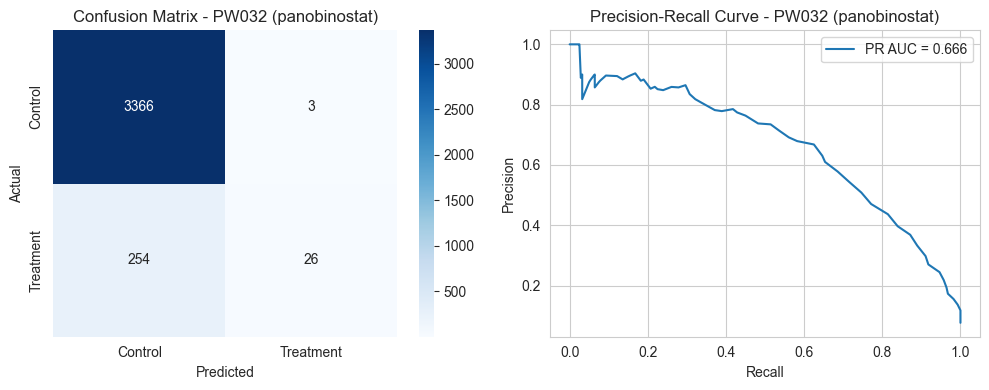

Classification Report:
               precision    recall  f1-score   support

     Control       0.88      1.00      0.93      3368
   Perturbed       0.76      0.09      0.16       502

    accuracy                           0.88      3870
   macro avg       0.82      0.54      0.55      3870
weighted avg       0.86      0.88      0.83      3870



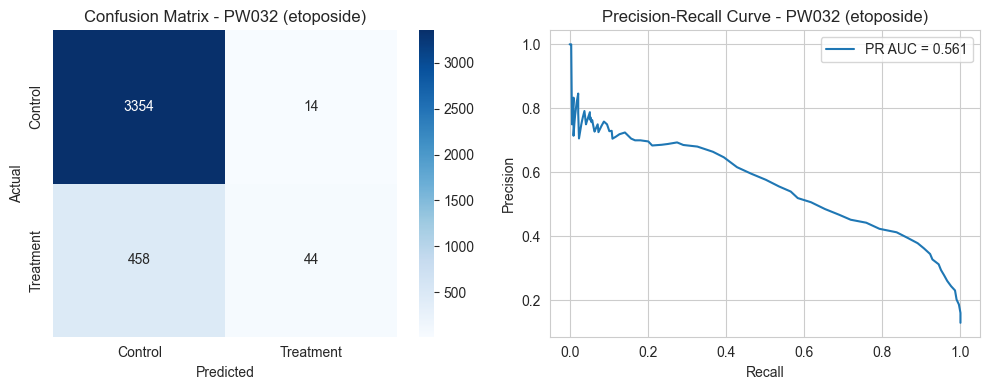

['panobinostat', 'control', 'etoposide']
Classification Report:
               precision    recall  f1-score   support

     Control       0.87      1.00      0.93      2658
   Perturbed       0.94      0.35      0.51       619

    accuracy                           0.87      3277
   macro avg       0.91      0.67      0.72      3277
weighted avg       0.88      0.87      0.85      3277



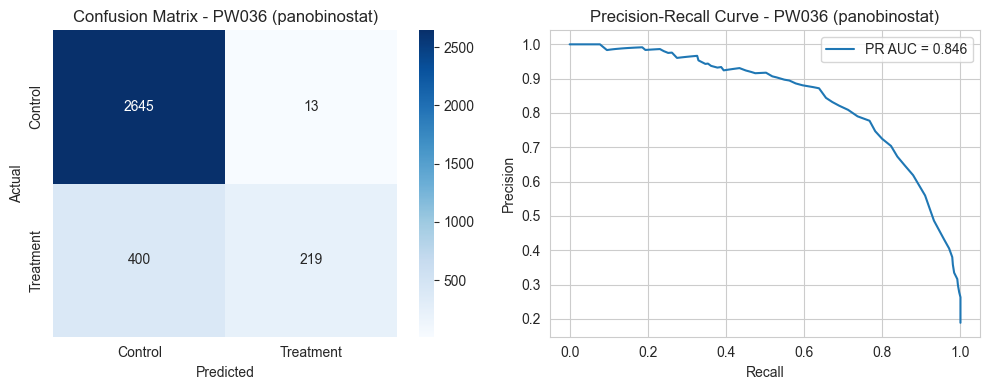

Classification Report:
               precision    recall  f1-score   support

     Control       0.79      0.96      0.87      2658
   Perturbed       0.84      0.45      0.59      1224

    accuracy                           0.80      3882
   macro avg       0.82      0.71      0.73      3882
weighted avg       0.81      0.80      0.78      3882



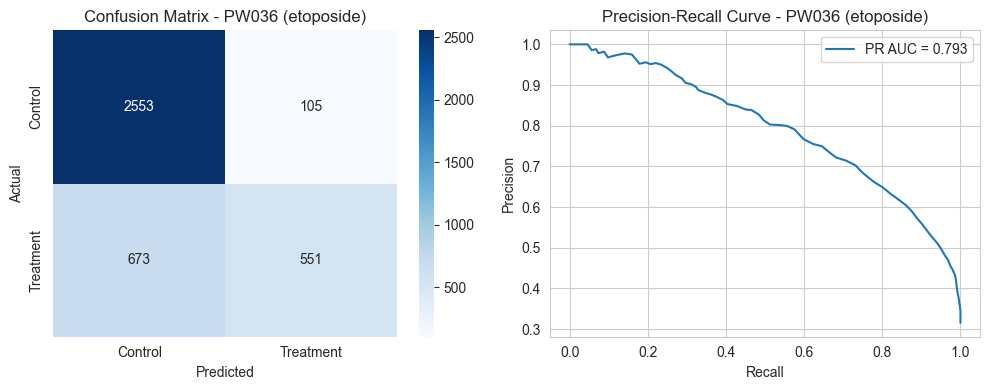

['control', 'panobinostat']
Classification Report:
               precision    recall  f1-score   support

     Control       0.89      1.00      0.94      2857
   Perturbed       0.80      0.08      0.15       397

    accuracy                           0.89      3254
   macro avg       0.85      0.54      0.54      3254
weighted avg       0.88      0.89      0.84      3254



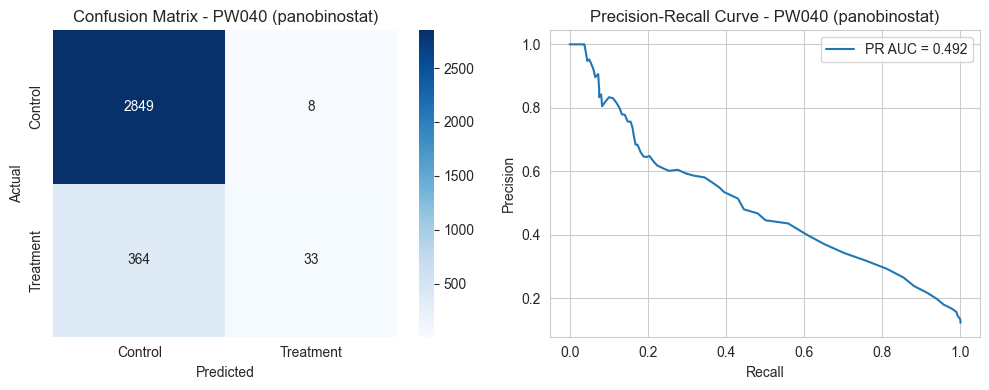

['etoposide', 'control']
Classification Report:
               precision    recall  f1-score   support

     Control       0.94      0.25      0.40       258
   Perturbed       0.79      0.99      0.88       719

    accuracy                           0.80       977
   macro avg       0.86      0.62      0.64       977
weighted avg       0.83      0.80      0.75       977



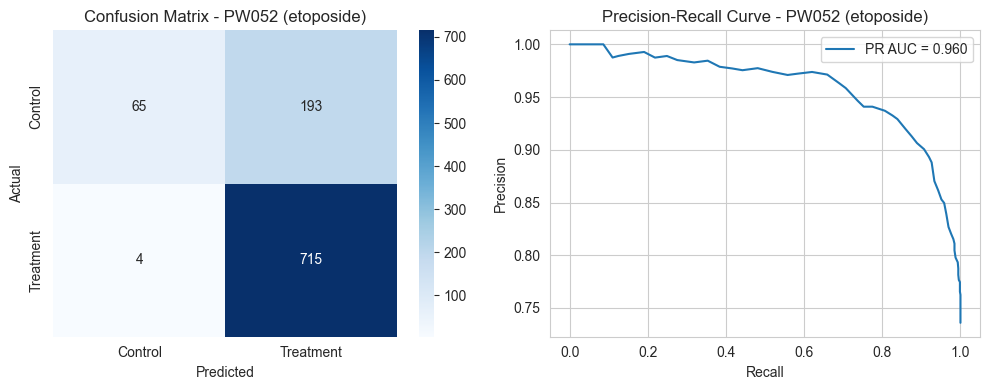

['control', 'Ana-12', 'etoposide', 'RO4929097', 'Tazemetostat', 'panobinostat', 'Ispenisib']
Classification Report:
               precision    recall  f1-score   support

     Control       0.91      0.98      0.94      4230
   Perturbed       0.90      0.71      0.79      1417

    accuracy                           0.91      5647
   macro avg       0.91      0.84      0.87      5647
weighted avg       0.91      0.91      0.90      5647



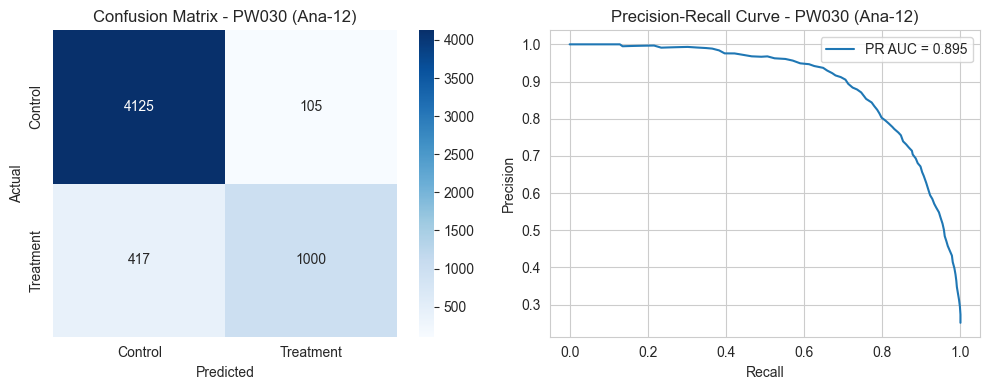

Classification Report:
               precision    recall  f1-score   support

     Control       0.96      1.00      0.98      4230
   Perturbed       0.99      0.77      0.86       788

    accuracy                           0.96      5018
   macro avg       0.97      0.88      0.92      5018
weighted avg       0.96      0.96      0.96      5018



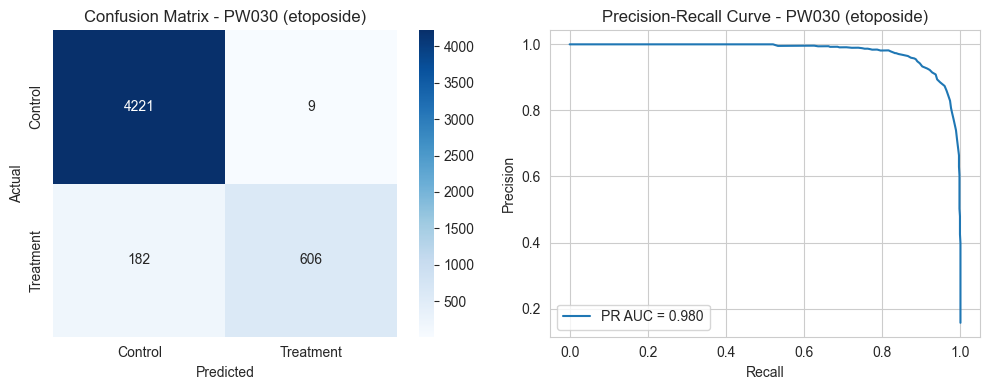

Classification Report:
               precision    recall  f1-score   support

     Control       0.91      1.00      0.95      4230
   Perturbed       0.98      0.59      0.74       961

    accuracy                           0.92      5191
   macro avg       0.95      0.79      0.84      5191
weighted avg       0.93      0.92      0.91      5191



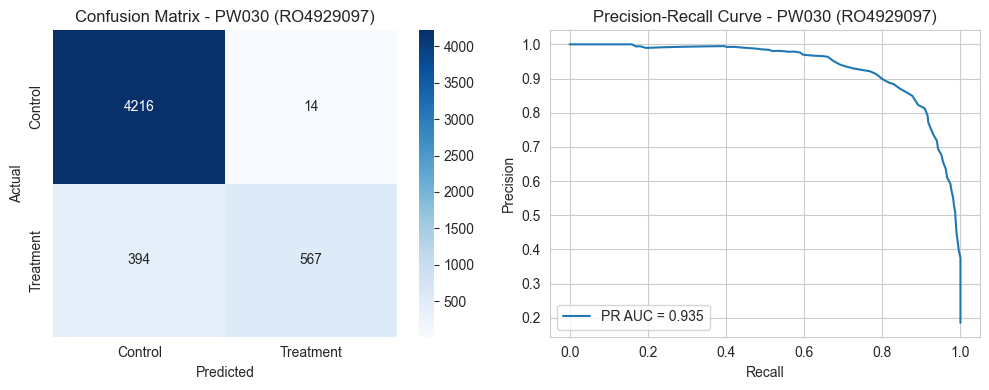

Classification Report:
               precision    recall  f1-score   support

     Control       0.95      1.00      0.97      4229
   Perturbed       0.98      0.75      0.85       826

    accuracy                           0.96      5055
   macro avg       0.97      0.87      0.91      5055
weighted avg       0.96      0.96      0.95      5055



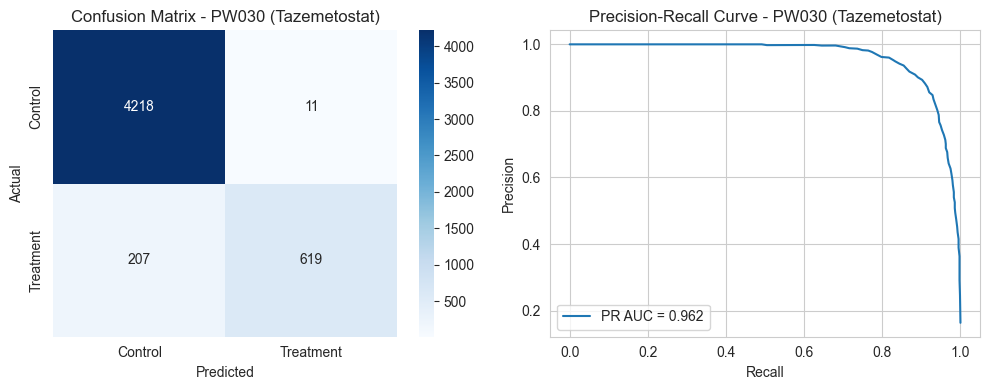

Classification Report:
               precision    recall  f1-score   support

     Control       0.97      1.00      0.98      4229
   Perturbed       0.99      0.90      0.94      1424

    accuracy                           0.97      5653
   macro avg       0.98      0.95      0.96      5653
weighted avg       0.97      0.97      0.97      5653



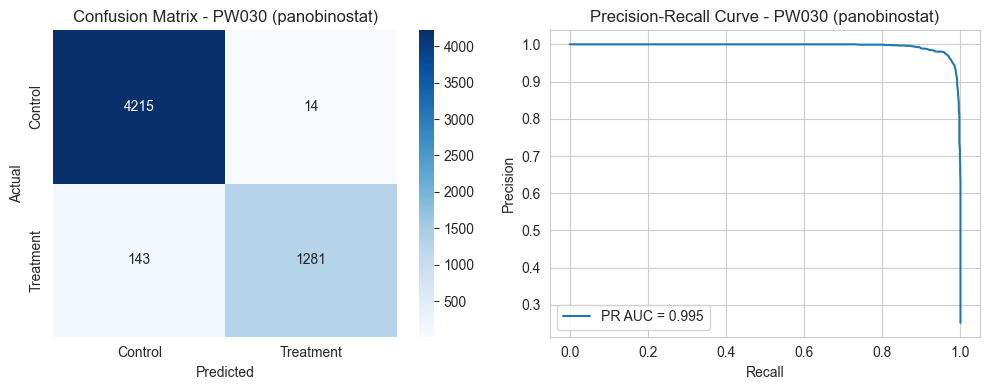

Classification Report:
               precision    recall  f1-score   support

     Control       0.94      1.00      0.97      4229
   Perturbed       1.00      0.50      0.66       537

    accuracy                           0.94      4766
   macro avg       0.97      0.75      0.82      4766
weighted avg       0.95      0.94      0.93      4766



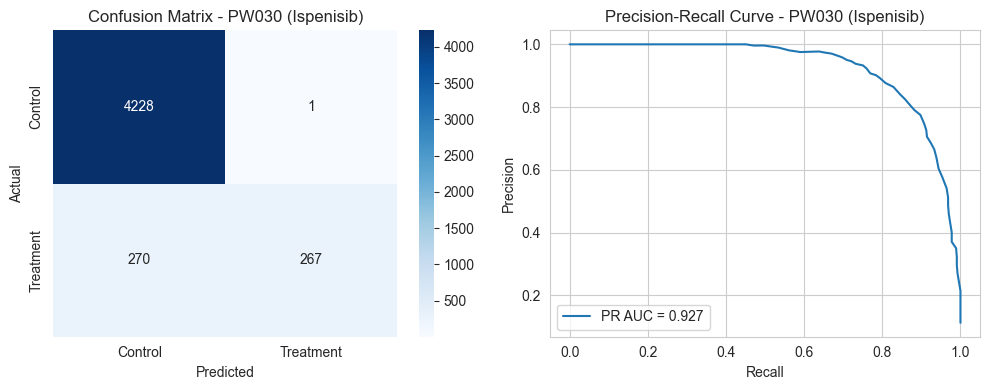

['control']
['panobinostat', 'control']
Classification Report:
               precision    recall  f1-score   support

     Control       0.99      0.53      0.69       276
   Perturbed       0.86      1.00      0.93       812

    accuracy                           0.88      1088
   macro avg       0.93      0.77      0.81      1088
weighted avg       0.90      0.88      0.87      1088



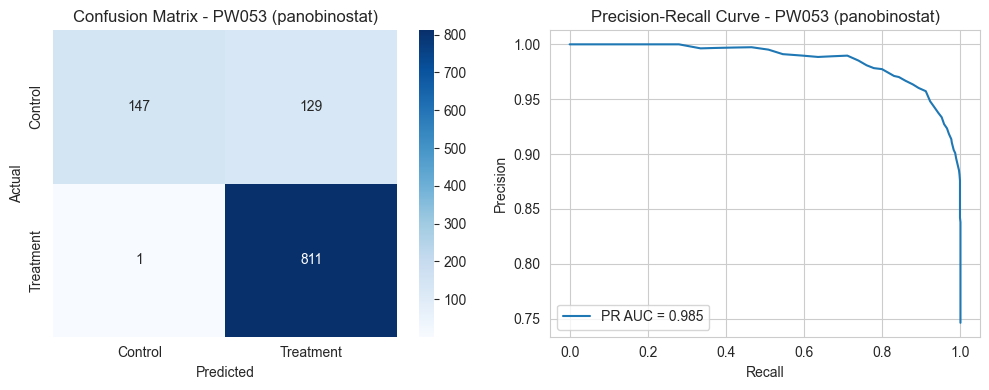

['control', 'etoposide']
Classification Report:
               precision    recall  f1-score   support

     Control       0.93      0.56      0.70       339
   Perturbed       0.85      0.98      0.91       891

    accuracy                           0.87      1230
   macro avg       0.89      0.77      0.81      1230
weighted avg       0.87      0.87      0.85      1230



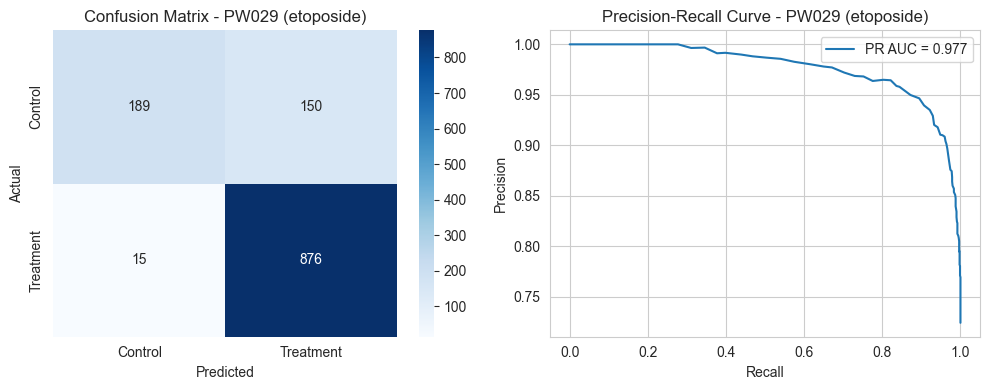

['control', 'panobinostat']
Classification Report:
               precision    recall  f1-score   support

     Control       0.86      0.91      0.88       386
   Perturbed       0.90      0.85      0.87       376

    accuracy                           0.88       762
   macro avg       0.88      0.88      0.88       762
weighted avg       0.88      0.88      0.88       762



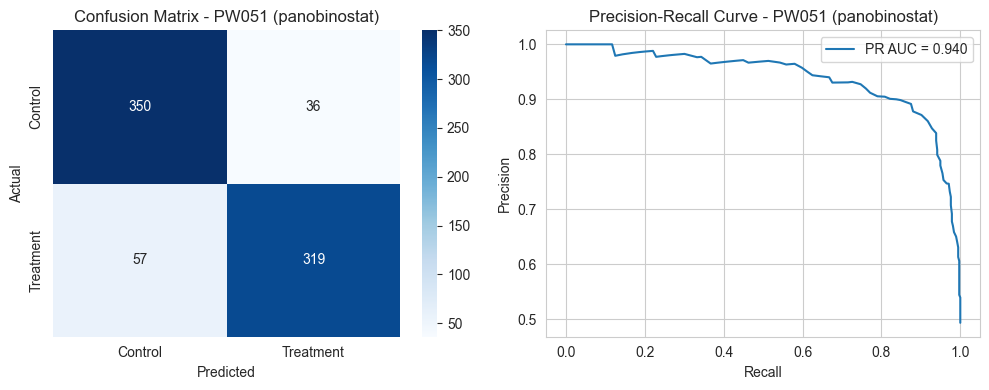

['control', 'panobinostat', 'etoposide']
Classification Report:
               precision    recall  f1-score   support

     Control       0.89      1.00      0.94      3058
   Perturbed       0.99      0.29      0.45       536

    accuracy                           0.89      3594
   macro avg       0.94      0.65      0.70      3594
weighted avg       0.91      0.89      0.87      3594



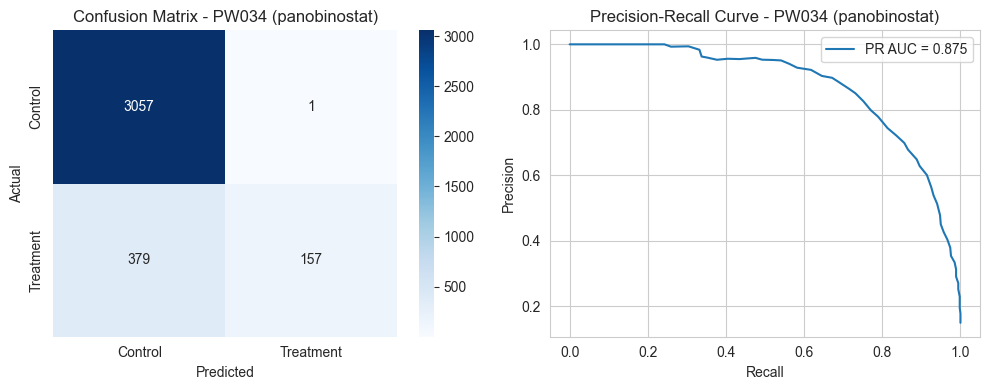

Classification Report:
               precision    recall  f1-score   support

     Control       0.83      0.89      0.86      3058
   Perturbed       0.89      0.82      0.85      3179

    accuracy                           0.85      6237
   macro avg       0.86      0.85      0.85      6237
weighted avg       0.86      0.85      0.85      6237



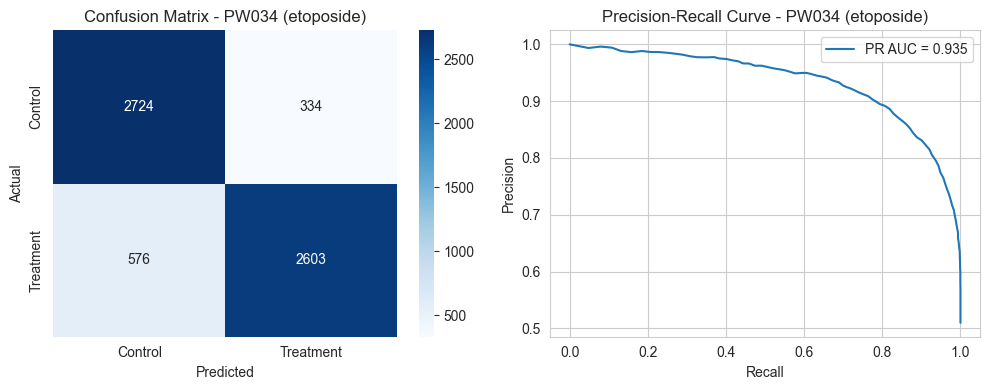

In [35]:
evaluate_classifier_rf(adata)